In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import BasicProcessor as bp

In [3]:
if '../Tracker' not in sys.path: sys.path.append('../Tracker')
import Tracker as t

In [4]:
mpl.rcParams.update({'font.size': 14})

In [5]:
video='20190520_105429'

In [67]:
df, X, Y, S, N, W, H = t.read_video_summary(video, filtered=True)

## Lanes Clustering

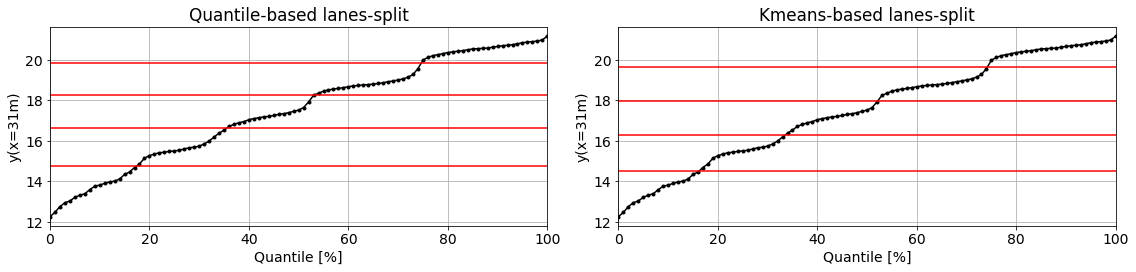

In [52]:
_, axs = plt.subplots(1,2, figsize=(16,4))

ax = axs[0]
cents = initial_centers
t.qplot(df.y_31, ax=ax, ylab='y(x=31m)', showmean=False)
ax.set_title('Quantile-based lanes-split')
for c1,c2 in zip(cents[:-1],cents[1:]):
    ax.axhline((c1+c2)/2, color='red')

ax = axs[1]
cents = kmeans.cluster_centers_
t.qplot(df.y_31, ax=ax, ylab='y(x=31m)', showmean=False)
ax.set_title('Kmeans-based lanes-split')
for c1,c2 in zip(cents[:-1],cents[1:]):
    ax.axhline((c1+c2)/2, color='red')

plt.tight_layout()

Near the bridge (x<=7), there's less visible area in the right lanes, thus the clustering is not reliable:

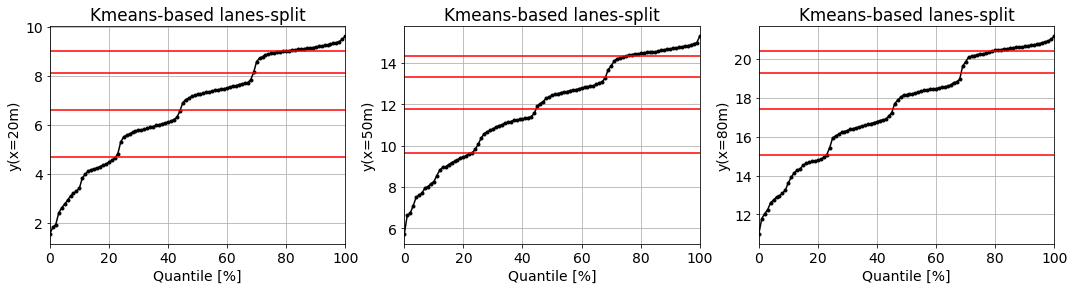

In [68]:
_, axs = plt.subplots(1,3,figsize=(18,4))
bp.cluster_lanes(df, show_lanes=[20,axs[0]])
bp.cluster_lanes(df, show_lanes=[50,axs[1]])
bp.cluster_lanes(df, show_lanes=[80,axs[2]]);

In [69]:
df

,video_group,video,vid_len,date,time,weekday,n_shots,consistent_xy_nas,continuous_track,avg_size,...,lane_26,lane_32,lane_38,lane_44,lane_50,lane_56,lane_62,lane_68,lane_74,lane_80
19,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,30,True,True,5.419062,...,1,1,1,1,1,1,1,1,1.0,1.0
18,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,40,True,True,4.693901,...,1,1,1,1,1,1,1,1,1.0,1.0
8,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,20,True,True,5.207388,...,2,2,2,2,2,2,2,2,2.0,2.0
22,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,21,True,False,4.333926,...,2,2,2,2,2,2,2,2,2.0,2.0
21,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,23,True,False,5.098568,...,3,3,3,3,3,3,3,3,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,27,True,False,4.299762,...,3,3,3,3,3,3,3,3,3.0,3.0
1365,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,30,True,True,4.862114,...,3,3,3,3,3,3,3,3,3.0,3.0
1372,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,28,True,False,5.090088,...,4,4,4,4,5,4,5,4,5.0,5.0
1380,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,27,True,False,4.995531,...,3,3,3,3,3,3,3,3,3.0,NaN


In [70]:
bp.cluster_lanes_for_all_videos(videos=['20190520_105429'])

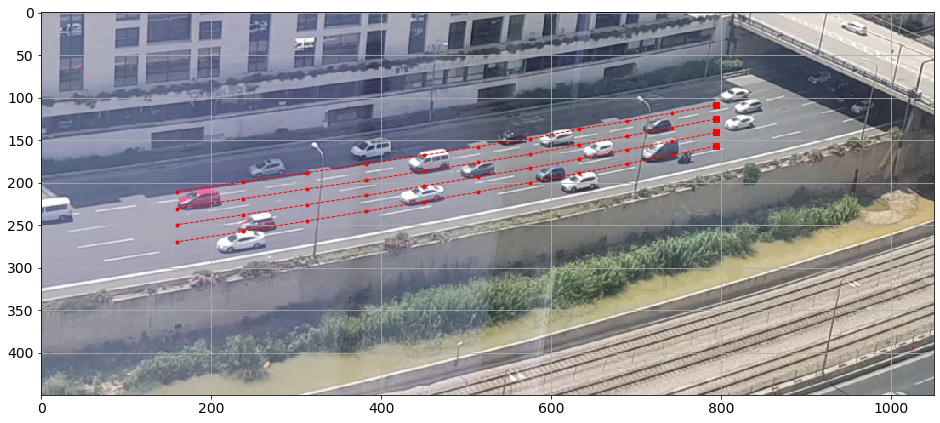

In [71]:
plt.figure(figsize=(16,8))
bp.plot_lanes(video, 0)
plt.grid()

#### Lane transitions - most of them are in the right lanes, near the entrances & exits:

In [23]:
lanes = df[[f'lane_{x:.0f}' for x in bp.X_REF]]
all_lanes = np.diff(lanes.values, axis=1).flatten()
transitions = Counter(all_lanes[np.logical_not(np.isnan(all_lanes))])
print(transitions)
df[(lanes.diff(axis=1).abs()>1).any(axis=1)]

Counter({0.0: 8227, 1.0: 108, -1.0: 95, -2.0: 1})


,video_group,video,vid_len,date,time,weekday,n_shots,consistent_xy_nas,continuous_track,avg_size,...,lane_26,lane_32,lane_38,lane_44,lane_50,lane_56,lane_62,lane_68,lane_74,lane_80
884,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,56,True,False,5.286919,...,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
n_transitions = np.sum([transitions[tr_size] for tr_size in transitions if tr_size!=0])
lane_transitions = pd.DataFrame(index=list(range(n_transitions)), columns=('x','lane_1','lane_2'))

i = 0
for car in lanes.index:
    for x1,x2 in zip(bp.X_REF[:-1],bp.X_REF[1:]):
        if np.logical_not(np.isnan(lanes.loc[car,f'lane_{x1:.0f}'])) and \
                np.logical_not(np.isnan(lanes.loc[car,f'lane_{x2:.0f}'])) and \
                lanes.loc[car,f'lane_{x1:.0f}'] != lanes.loc[car,f'lane_{x2:.0f}']:
            lane_transitions.iloc[i,0] = x1
            lane_transitions.iloc[i,1] = lanes.loc[car,f'lane_{x1:.0f}']
            lane_transitions.iloc[i,2] = lanes.loc[car,f'lane_{x2:.0f}']
            i += 1
            
lane_transitions

,x,lane_1,lane_2
0,74,1,2
1,50,2,1
2,38,3,4
3,44,2,3
4,38,2,1
...,...,...,...
199,38,3,2
200,26,1,2
201,32,3,2
202,20,2,1


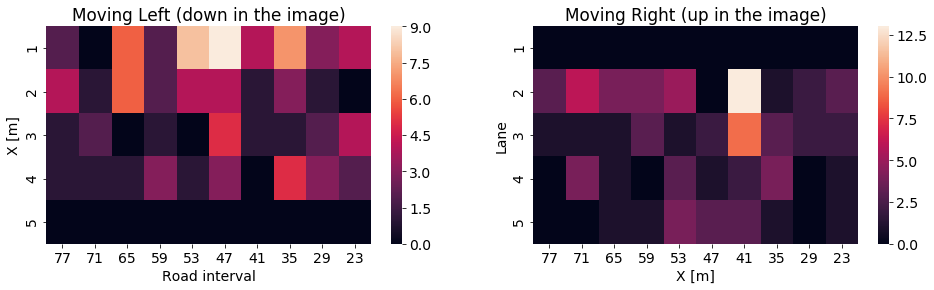

In [31]:
lane_transitions_d = lane_transitions[lane_transitions.lane_2>lane_transitions.lane_1]
lane_transitions_u = lane_transitions[lane_transitions.lane_2<lane_transitions.lane_1]
trans_per_cell_d = np.zeros((5,len(bp.X_REF)))
trans_per_cell_u = np.zeros((5,len(bp.X_REF)))
for i,l in enumerate(range(1,6)):
    for j,x0 in enumerate(bp.X_REF):
        trans_per_cell_d[i,j] = ((lane_transitions_d.x==x0) & (lane_transitions_d.lane_1==l)).sum()
        trans_per_cell_u[i,j] = ((lane_transitions_u.x==x0) & (lane_transitions_u.lane_1==l)).sum()

_, axs = plt.subplots(1,2, figsize=(16,4))

ax = axs[0]
# last x-interval is irrelevant because there can be no more transitions after it...
sns.heatmap(trans_per_cell_d[:,:-1],
            xticklabels=np.array((bp.X_REF[1:]+bp.X_REF[:-1])/2,dtype=int), yticklabels=1+np.arange(5), ax=ax)
ax.invert_xaxis()
ax.set_title('Moving Left (down in the image)')
ax.set_xlabel('Road interval')
ax.set_ylabel('X [m]')

ax = axs[1]
sns.heatmap(trans_per_cell_u[:,:-1],
            xticklabels=np.array((bp.X_REF[1:]+bp.X_REF[:-1])/2,dtype=int), yticklabels=1+np.arange(5), ax=ax)
ax.invert_xaxis()
ax.set_title('Moving Right (up in the image)')
ax.set_xlabel('X [m]')
ax.set_ylabel('Lane');

## Spatial Summary

In [72]:
bp.save_spatial_summaries(videos=[video], notebook=True)

In [73]:
S = bp.merge_spatial_summaries(videos=[video], to_save=False)

In [74]:
S

,t,n_detections,n_tracks,n_x20to26_l1,v_x20to26_l1,n_x20to26_l2,v_x20to26_l2,n_x20to26_l3,v_x20to26_l3,n_x20to26_l4,...,n_x74to80_l1,v_x74to80_l1,n_x74to80_l2,v_x74to80_l2,n_x74to80_l3,v_x74to80_l3,n_x74to80_l4,v_x74to80_l4,n_x74to80_l5,v_x74to80_l5
0,0.000000,20.0,19,0,NaN,0,NaN,0,NaN,0,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
1,0.266667,20.0,21,0,NaN,0,NaN,0,NaN,0,...,0,NaN,0,NaN,0,NaN,1,12.656952,0,NaN
2,0.533333,18.0,21,1,8.985662,0,NaN,1,12.164381,0,...,1,8.566192,0,NaN,0,NaN,1,12.656952,0,NaN
3,0.800000,19.0,20,1,8.985662,1,8.444815,0,NaN,0,...,1,8.566192,0,NaN,0,NaN,0,NaN,0,NaN
4,1.066667,19.0,18,0,NaN,1,8.444815,0,NaN,0,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1622,432.533333,31.0,28,0,NaN,1,1.243838,1,6.584988,1,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
1623,432.800000,30.0,28,0,NaN,1,1.243838,1,6.584988,1,...,0,NaN,0,NaN,1,10.195667,0,NaN,0,NaN
1624,433.066667,32.0,29,1,NaN,1,1.243838,1,6.584988,0,...,0,NaN,0,NaN,1,10.195667,1,NaN,1,10.533358
1625,433.333333,29.0,29,1,NaN,1,1.243838,0,NaN,0,...,0,NaN,0,NaN,1,10.195667,1,NaN,1,10.533358


In [75]:
S.columns

Index(['t', 'n_detections', 'n_tracks', 'n_x20to26_l1', 'v_x20to26_l1',
       'n_x20to26_l2', 'v_x20to26_l2', 'n_x20to26_l3', 'v_x20to26_l3',
       'n_x20to26_l4',
       ...
       'n_x74to80_l1', 'v_x74to80_l1', 'n_x74to80_l2', 'v_x74to80_l2',
       'n_x74to80_l3', 'v_x74to80_l3', 'n_x74to80_l4', 'v_x74to80_l4',
       'n_x74to80_l5', 'v_x74to80_l5'],
      dtype='object', length=103)

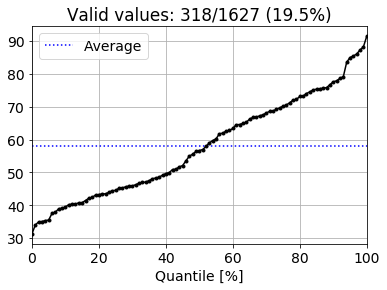

In [76]:
t.qplot(3.6*S.v_x44to50_l5)

In [ ]:
# Save spatial summary with all tracks (including invalid ones)
bp.save_spatial_summaries(do_filter=False, notebook=True, verbose=1)
bp.merge_spatial_summaries(suffix='spatial', to_save=True, filename='summary_per_area')

In [ ]:
# Save spatial summary with filtered tracks
bp.save_spatial_summaries(do_filter=True, notebook=True, verbose=1)
bp.merge_spatial_summaries(suffix='spatial_filtered', to_save=True, filename='summary_per_area_filtered')

# SLOW SPEED DEBUGGING

In [78]:
print(df.columns)
df

Index(['video_group', 'video', 'vid_len', 'date', 'time', 'weekday', 'n_shots',
       'consistent_xy_nas', 'continuous_track', 'avg_size', 'max_size',
       'valid_size', 'neg_x_motion', 'neg_y_motion', 'valid_x_dir',
       'valid_y_dir', 'min_x', 'max_x', 'min_y', 'max_y', 't0', 'dt', 'dx',
       'dy', 'x_path_rel', 'y_path_rel', 'long_path', 'v', 'abs_v', 'v_sd',
       'road_slope', 'road_perpendicularity', 'perpendicular_range', 'y_20',
       'y_26', 'y_32', 'y_38', 'y_44', 'y_50', 'y_56', 'y_62', 'y_68', 'y_74',
       'y_80', 't_20', 't_26', 't_32', 't_38', 't_44', 't_50', 't_56', 't_62',
       't_68', 't_74', 't_80', 's_20', 's_26', 's_32', 's_38', 's_44', 's_50',
       's_56', 's_62', 's_68', 's_74', 's_80', 'lane_20', 'lane_26', 'lane_32',
       'lane_38', 'lane_44', 'lane_50', 'lane_56', 'lane_62', 'lane_68',
       'lane_74', 'lane_80'],
      dtype='object')


,video_group,video,vid_len,date,time,weekday,n_shots,consistent_xy_nas,continuous_track,avg_size,...,lane_26,lane_32,lane_38,lane_44,lane_50,lane_56,lane_62,lane_68,lane_74,lane_80
19,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,30,True,True,5.419062,...,1,1,1,1,1,1,1,1,1.0,1.0
18,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,40,True,True,4.693901,...,1,1,1,1,1,1,1,1,1.0,1.0
8,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,20,True,True,5.207388,...,2,2,2,2,2,2,2,2,2.0,2.0
22,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,21,True,False,4.333926,...,2,2,2,2,2,2,2,2,2.0,2.0
21,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,23,True,False,5.098568,...,3,3,3,3,3,3,3,3,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,27,True,False,4.299762,...,3,3,3,3,3,3,3,3,3.0,3.0
1365,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,30,True,True,4.862114,...,3,3,3,3,3,3,3,3,3.0,3.0
1372,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,28,True,False,5.090088,...,4,4,4,4,5,4,5,4,5.0,5.0
1380,1,20190520_105429.mp4,7.231111,20190520,10.908056,2,27,True,False,4.995531,...,3,3,3,3,3,3,3,3,3.0,NaN


0.5981308411214953

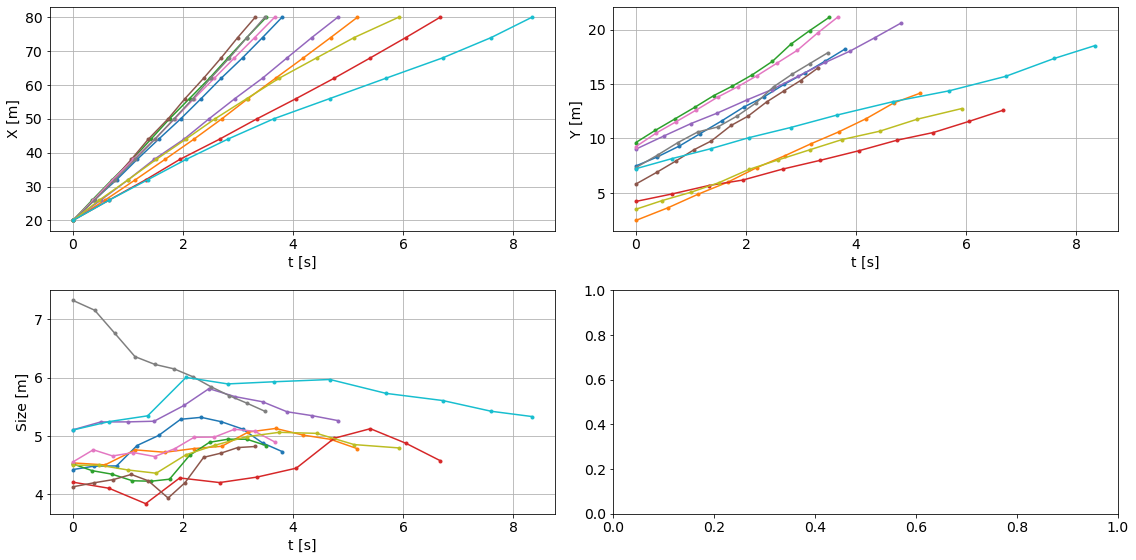

In [83]:
n = 10

cars = np.random.choice(df.index, n)
x = bp.X_REF

y_cols = np.array([f'y_{xx:.0f}' for xx in x])
y = [np.array(df.loc[car,y_cols]) for car in cars]
s_cols = np.array([f's_{xx:.0f}' for xx in x])
s = [np.array(df.loc[car,s_cols]) for car in cars]
t_cols = np.array([f't_{xx:.0f}' for xx in x])
t = [np.array(df.loc[car,t_cols]) for car in cars]

_, axs = plt.subplots(2,2, figsize=(16,8))

ax = axs[0,0]
for i in range(n):
    ax.plot(t[i]-t[i][0], x, '.-')
ax.set_xlabel('t [s]')
ax.set_ylabel('X [m]')
ax.grid()

ax = axs[0,1]
for i in range(n):
    ax.plot(t[i]-t[i][0], y[i], '.-')
ax.set_xlabel('t [s]')
ax.set_ylabel('Y [m]')
ax.grid()

ax = axs[1,0]
for i in range(n):
    ax.plot(t[i]-t[i][0], s[i], '.-')
ax.set_xlabel('t [s]')
ax.set_ylabel('Size [m]')
ax.grid()

plt.tight_layout()